In [ ]:
!pip install sentencepiece nltk rouge-score

import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import random
import sentencepiece as spm
import os
import nltk
nltk.download('punkt')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_path = '/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv'
df = pd.read_csv(data_path)

def combine_poems(df):
    poems = df.groupby('gid')['s'].apply(lambda x: ' '.join(x)).reset_index()
    return poems

poems_df = combine_poems(df)
print(f'Total poems: {len(poems_df)}')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\n\s]", '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

poems_df['s'] = poems_df['s'].apply(preprocess_text)

temp_text_file = 'poems.txt'
poems_df['s'].to_csv(temp_text_file, index=False, header=False)

spm_model_prefix = 'bpe_tokenizer'
vocab_size = 8000

if not os.path.exists(f'{spm_model_prefix}.model'):
    spm.SentencePieceTrainer.Train(
        input=temp_text_file,
        model_prefix=spm_model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        character_coverage=1.0,
        unk_id=1,
        pad_id=0,
        bos_id=2,
        eos_id=3,
        user_defined_symbols=''
    )

tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{spm_model_prefix}.model')

class PoetryDataset(Dataset):
    def __init__(self, poems, tokenizer, max_length=100):
        self.poems = poems
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []
        self.targets = []
        self.prepare_data()
    
    def prepare_data(self):
        for poem in self.poems:
            tokens = self.tokenizer.encode(poem, out_type=int)
            tokens = [self.tokenizer.bos_id()] + tokens + [self.tokenizer.eos_id()]
            if len(tokens) > self.max_length:
                tokens = tokens[:self.max_length]
                tokens[-1] = self.tokenizer.eos_id()
            else:
                tokens += [self.tokenizer.pad_id()] * (self.max_length - len(tokens))
            self.inputs.append(tokens[:-1])
            self.targets.append(tokens[1:])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

train_size = int(0.9 * len(poems_df))
train_poems = poems_df['s'].iloc[:train_size].tolist()
val_poems = poems_df['s'].iloc[train_size:].tolist()

train_dataset = PoetryDataset(train_poems, tokenizer, max_length=100)
val_dataset = PoetryDataset(val_poems, tokenizer, max_length=100)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

os.remove(temp_text_file)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda
Total poems: 1191
Training samples: 1071
Validation samples: 120


In [4]:
!pip install matplotlib tqdm nltk rouge


Using device: cuda
TransformerModel(
  (embedding): Embedding(8000, 512, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (linear_q): Linear(in_features=512, out_features=512, bias=True)
        (linear_k): Linear(in_features=512, out_features=512, bias=True)
        (linear_v): Linear(in_features=512, out_features=512, bias=True)
        (linear_out): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_

Epoch 1 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.10it/s]


Epoch 1 | Train Loss: 10.1187 | Val Loss: 10.0705


Epoch 2 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.99it/s]


Epoch 2 | Train Loss: 10.1127 | Val Loss: 10.0705


Epoch 3 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.28it/s]


Epoch 3 | Train Loss: 10.1120 | Val Loss: 10.0705


Epoch 4 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.15it/s]


Epoch 4 | Train Loss: 10.1127 | Val Loss: 10.0704


Epoch 5 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.09it/s]


Epoch 5 | Train Loss: 10.1126 | Val Loss: 10.0704


Epoch 6 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.28it/s]


Epoch 6 | Train Loss: 10.1122 | Val Loss: 10.0704


Epoch 7 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.00it/s]


Epoch 7 | Train Loss: 10.1121 | Val Loss: 10.0703


Epoch 8 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


Epoch 8 | Train Loss: 10.1114 | Val Loss: 10.0702


Epoch 9 Validation: 100%|██████████| 120/120 [00:03<00:00, 33.90it/s]


Epoch 9 | Train Loss: 10.1120 | Val Loss: 10.0701


Epoch 10 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.69it/s]


Epoch 10 | Train Loss: 10.1238 | Val Loss: 10.0700


Epoch 11 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.36it/s]


Epoch 11 | Train Loss: 10.1129 | Val Loss: 10.0699


Epoch 12 Validation: 100%|██████████| 120/120 [00:03<00:00, 33.92it/s]


Epoch 12 | Train Loss: 10.1118 | Val Loss: 10.0698


Epoch 13 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.49it/s]


Epoch 13 | Train Loss: 10.1112 | Val Loss: 10.0697


Epoch 14 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.38it/s]


Epoch 14 | Train Loss: 10.1121 | Val Loss: 10.0695


Epoch 15 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.54it/s]


Epoch 15 | Train Loss: 10.1119 | Val Loss: 10.0693


Epoch 16 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.83it/s]


Epoch 16 | Train Loss: 10.1109 | Val Loss: 10.0691


Epoch 17 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.58it/s]


Epoch 17 | Train Loss: 10.1114 | Val Loss: 10.0690


Epoch 18 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.65it/s]


Epoch 18 | Train Loss: 10.1114 | Val Loss: 10.0687


Epoch 19 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.85it/s]


Epoch 19 | Train Loss: 10.1113 | Val Loss: 10.0685


Epoch 20 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.59it/s]


Epoch 20 | Train Loss: 10.1178 | Val Loss: 10.0683


Epoch 21 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.53it/s]


Epoch 21 | Train Loss: 10.1120 | Val Loss: 10.0681


Epoch 22 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.31it/s]


Epoch 22 | Train Loss: 10.1108 | Val Loss: 10.0678


Epoch 23 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.81it/s]


Epoch 23 | Train Loss: 10.1101 | Val Loss: 10.0675


Epoch 24 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.48it/s]


Epoch 24 | Train Loss: 10.1094 | Val Loss: 10.0672


Epoch 25 Validation: 100%|██████████| 120/120 [00:03<00:00, 33.99it/s]


Epoch 25 | Train Loss: 10.1094 | Val Loss: 10.0669


Epoch 26 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.84it/s]


Epoch 26 | Train Loss: 10.1097 | Val Loss: 10.0666


Epoch 27 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.91it/s]


Epoch 27 | Train Loss: 10.1101 | Val Loss: 10.0663


Epoch 28 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.62it/s]


Epoch 28 | Train Loss: 10.1085 | Val Loss: 10.0660


Epoch 29 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.28it/s]


Epoch 29 | Train Loss: 10.1082 | Val Loss: 10.0657


Epoch 30 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.17it/s]


Epoch 30 | Train Loss: 10.1149 | Val Loss: 10.0654


Epoch 31 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.07it/s]


Epoch 31 | Train Loss: 10.1078 | Val Loss: 10.0650


Epoch 32 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.93it/s]


Epoch 32 | Train Loss: 10.1203 | Val Loss: 10.0647


Epoch 33 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.35it/s]


Epoch 33 | Train Loss: 10.1064 | Val Loss: 10.0643


Epoch 34 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.38it/s]


Epoch 34 | Train Loss: 10.1131 | Val Loss: 10.0639


Epoch 35 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.27it/s]


Epoch 35 | Train Loss: 10.1066 | Val Loss: 10.0636


Epoch 36 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


Epoch 36 | Train Loss: 10.1044 | Val Loss: 10.0631


Epoch 37 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.05it/s]


Epoch 37 | Train Loss: 10.1130 | Val Loss: 10.0627


Epoch 38 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.76it/s]


Epoch 38 | Train Loss: 10.1054 | Val Loss: 10.0623


Epoch 39 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.05it/s]


Epoch 39 | Train Loss: 10.1064 | Val Loss: 10.0619


Epoch 40 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.13it/s]


Epoch 40 | Train Loss: 10.1055 | Val Loss: 10.0614


Epoch 41 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.21it/s]


Epoch 41 | Train Loss: 10.1123 | Val Loss: 10.0610


Epoch 42 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.12it/s]


Epoch 42 | Train Loss: 10.1045 | Val Loss: 10.0605


Epoch 43 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.31it/s]


Epoch 43 | Train Loss: 10.1039 | Val Loss: 10.0600


Epoch 44 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.69it/s]


Epoch 44 | Train Loss: 10.1038 | Val Loss: 10.0595


Epoch 45 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.29it/s]


Epoch 45 | Train Loss: 10.1030 | Val Loss: 10.0590


Epoch 46 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.73it/s]


Epoch 46 | Train Loss: 10.1031 | Val Loss: 10.0584


Epoch 47 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.33it/s]


Epoch 47 | Train Loss: 10.1011 | Val Loss: 10.0579


Epoch 48 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.27it/s]


Epoch 48 | Train Loss: 10.1015 | Val Loss: 10.0573


Epoch 49 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.51it/s]


Epoch 49 | Train Loss: 10.1079 | Val Loss: 10.0568


Epoch 50 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.05it/s]


Epoch 50 | Train Loss: 10.1059 | Val Loss: 10.0562


Epoch 51 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.48it/s]


Epoch 51 | Train Loss: 10.1056 | Val Loss: 10.0556


Epoch 52 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.96it/s]


Epoch 52 | Train Loss: 10.1065 | Val Loss: 10.0550


Epoch 53 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.91it/s]


Epoch 53 | Train Loss: 10.0985 | Val Loss: 10.0544


Epoch 54 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.84it/s]


Epoch 54 | Train Loss: 10.0981 | Val Loss: 10.0538


Epoch 55 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.46it/s]


Epoch 55 | Train Loss: 10.0975 | Val Loss: 10.0531


Epoch 56 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


Epoch 56 | Train Loss: 10.0965 | Val Loss: 10.0525


Epoch 57 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.51it/s]


Epoch 57 | Train Loss: 10.1116 | Val Loss: 10.0518


Epoch 58 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.18it/s]


Epoch 58 | Train Loss: 10.0964 | Val Loss: 10.0512


Epoch 59 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.65it/s]


Epoch 59 | Train Loss: 10.0949 | Val Loss: 10.0505


Epoch 60 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.30it/s]


Epoch 60 | Train Loss: 10.0942 | Val Loss: 10.0499


Epoch 61 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.18it/s]


Epoch 61 | Train Loss: 10.1013 | Val Loss: 10.0492


Epoch 62 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.05it/s]


Epoch 62 | Train Loss: 10.0931 | Val Loss: 10.0485


Epoch 63 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.24it/s]


Epoch 63 | Train Loss: 10.0933 | Val Loss: 10.0478


Epoch 64 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.04it/s]


Epoch 64 | Train Loss: 10.0923 | Val Loss: 10.0470


Epoch 65 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.12it/s]


Epoch 65 | Train Loss: 10.0906 | Val Loss: 10.0463


Epoch 66 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.78it/s]


Epoch 66 | Train Loss: 10.0912 | Val Loss: 10.0456


Epoch 67 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.65it/s]


Epoch 67 | Train Loss: 10.0910 | Val Loss: 10.0448


Epoch 68 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.47it/s]


Epoch 68 | Train Loss: 10.0884 | Val Loss: 10.0440


Epoch 69 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.67it/s]


Epoch 69 | Train Loss: 10.0894 | Val Loss: 10.0433


Epoch 70 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.03it/s]


Epoch 70 | Train Loss: 10.0880 | Val Loss: 10.0425


Epoch 71 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.83it/s]


Epoch 71 | Train Loss: 10.0879 | Val Loss: 10.0416


Epoch 72 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.57it/s]


Epoch 72 | Train Loss: 10.0872 | Val Loss: 10.0408


Epoch 73 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.24it/s]


Epoch 73 | Train Loss: 10.0929 | Val Loss: 10.0400


Epoch 74 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.02it/s]


Epoch 74 | Train Loss: 10.0853 | Val Loss: 10.0391


Epoch 75 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.90it/s]


Epoch 75 | Train Loss: 10.0850 | Val Loss: 10.0383


Epoch 76 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.75it/s]


Epoch 76 | Train Loss: 10.0839 | Val Loss: 10.0374


Epoch 77 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.73it/s]


Epoch 77 | Train Loss: 10.0823 | Val Loss: 10.0365


Epoch 78 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.96it/s]


Epoch 78 | Train Loss: 10.0889 | Val Loss: 10.0356


Epoch 79 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.21it/s]


Epoch 79 | Train Loss: 10.0800 | Val Loss: 10.0347


Epoch 80 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.63it/s]


Epoch 80 | Train Loss: 10.0802 | Val Loss: 10.0338


Epoch 81 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.88it/s]


Epoch 81 | Train Loss: 10.0860 | Val Loss: 10.0329


Epoch 82 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.01it/s]


Epoch 82 | Train Loss: 10.0865 | Val Loss: 10.0319


Epoch 83 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.73it/s]


Epoch 83 | Train Loss: 10.0786 | Val Loss: 10.0310


Epoch 84 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.98it/s]


Epoch 84 | Train Loss: 10.0777 | Val Loss: 10.0300


Epoch 85 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.52it/s]


Epoch 85 | Train Loss: 10.0752 | Val Loss: 10.0291


Epoch 86 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.56it/s]


Epoch 86 | Train Loss: 10.0809 | Val Loss: 10.0281


Epoch 87 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.21it/s]


Epoch 87 | Train Loss: 10.0750 | Val Loss: 10.0272


Epoch 88 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.15it/s]


Epoch 88 | Train Loss: 10.0735 | Val Loss: 10.0262


Epoch 89 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.19it/s]


Epoch 89 | Train Loss: 10.0721 | Val Loss: 10.0252


Epoch 90 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.18it/s]


Epoch 90 | Train Loss: 10.0714 | Val Loss: 10.0242


Epoch 91 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.09it/s]


Epoch 91 | Train Loss: 10.0703 | Val Loss: 10.0231


Epoch 92 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.97it/s]


Epoch 92 | Train Loss: 10.0710 | Val Loss: 10.0221


Epoch 93 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.06it/s]


Epoch 93 | Train Loss: 10.0687 | Val Loss: 10.0211


Epoch 94 Validation: 100%|██████████| 120/120 [00:03<00:00, 34.69it/s]


Epoch 94 | Train Loss: 10.0674 | Val Loss: 10.0200


Epoch 95 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.11it/s]


Epoch 95 | Train Loss: 10.0675 | Val Loss: 10.0189


Epoch 96 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.71it/s]


Epoch 96 | Train Loss: 10.0663 | Val Loss: 10.0178


Epoch 97 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.05it/s]


Epoch 97 | Train Loss: 10.0649 | Val Loss: 10.0167


Epoch 98 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.62it/s]


Epoch 98 | Train Loss: 10.0642 | Val Loss: 10.0156


Epoch 99 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.25it/s]


Epoch 99 | Train Loss: 10.0684 | Val Loss: 10.0145


Epoch 100 Validation: 100%|██████████| 120/120 [00:03<00:00, 35.10it/s]


Epoch 100 | Train Loss: 10.0625 | Val Loss: 10.0134


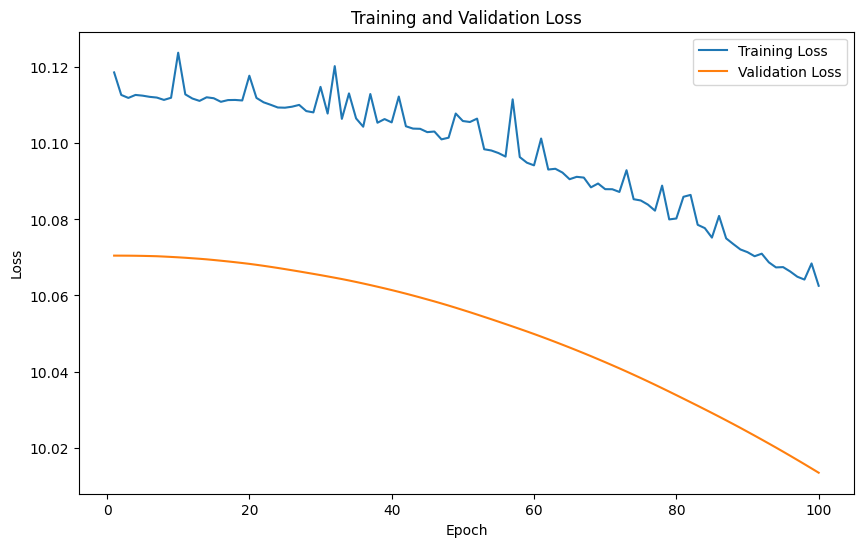

/tmp/ipykernel_232/1319430694.py:396: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))
Evaluating Metrics: 100%|

BLEU Score: 0.0001
ROUGE Scores: {'rouge-1': {'r': 0.013867562016232921, 'p': 0.011295524442403514, 'f': 0.01232257559363732}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.013317178757516328, 'p': 0.010830338168524228, 'f': 0.011819513676630861}}
Generated Poetry:
insteadits oozeitivepenedessingpened mdcccxc sometim offavern greeting meeting wishesavern zoologypenedlishment sawbirds grasses painteditaliz chilling qweed feathers coloracco teamuting putting berylauce grimalkinapscorner wind!) boxvery fru she eng pump cock gather credit payachman say 1 scenes largepte selachman tou bringing ways we stan catsaffed coloursount!)ployedfume lurk mdcccxc capering viumpet thanklishment zoologyalling certainger clownsoring instead centuryise slumberidge swings learning capering lame catspte spoon consid we believing present tou kill


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.nn import functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import nltk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_len, d_model).float()
        pe.requires_grad = False
        
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)).exp()
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.attention = None
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.linear_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.linear_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)
            mask = mask.to(torch.bool)
            mask = mask.expand(batch_size, self.num_heads, -1, -1)
            scores = scores.masked_fill(~mask, float('-inf'))
        
        attn = F.softmax(scores, dim=-1)
        self.attention = attn
        attn = self.dropout(attn)
        
        output = torch.matmul(attn, V)
        
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        
        return self.linear_out(output)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        attn = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn))
        ff = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask, tgt_mask):
        self_attn = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn))
        cross_attn = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(cross_attn))
        ff = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff))
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_encoder_layers=4, 
                 num_decoder_layers=4, d_ff=1024, dropout=0.2, max_seq_length=100):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_length, dropout=dropout)
        
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_encoder_layers)
        ])
        
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_decoder_layers)
        ])
        
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.init_weights()
        
        self.gradient_checkpointing = True
    
    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embedding.weight, -initrange, initrange)
        if self.embedding.padding_idx is not None:
            with torch.no_grad():
                self.embedding.weight[self.embedding.padding_idx].fill_(0)
        self.fc_out.bias.data.zero_()
        nn.init.xavier_uniform_(self.fc_out.weight)
    
    def make_src_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask.to(torch.bool)
    
    def make_tgt_mask(self, tgt):
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_len = tgt.size(1)
        subsequent_mask = torch.tril(torch.ones((seq_len, seq_len), device=tgt.device)).bool()
        subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(0)
        tgt_mask = tgt_pad_mask & subsequent_mask
        return tgt_mask.to(torch.bool)
    
    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        
        enc_emb = self.pos_encoder(self.embedding(src) * math.sqrt(self.d_model))
        dec_emb = self.pos_encoder(self.embedding(tgt) * math.sqrt(self.d_model))
        
        enc_output = enc_emb
        for layer in self.encoder_layers:
            if self.gradient_checkpointing:
                enc_output = torch.utils.checkpoint.checkpoint(layer, enc_output, src_mask)
            else:
                enc_output = layer(enc_output, src_mask)
        
        dec_output = dec_emb
        for layer in self.decoder_layers:
            if self.gradient_checkpointing:
                dec_output = torch.utils.checkpoint.checkpoint(layer, dec_output, enc_output, src_mask, tgt_mask)
            else:
                dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)
        
        output = self.fc_out(dec_output)
        return output

VOCAB_SIZE = 8000
d_model = 512

model = TransformerModel(
    vocab_size=VOCAB_SIZE,
    d_model=d_model,
    num_heads=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    d_ff=2048,
    dropout=0.2,
    max_seq_length=100
).to(device)

print(model)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.ignore_index = ignore_index
        
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        
        true_dist = torch.full_like(log_probs, self.smoothing / (self.classes - 2))
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        true_dist.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

criterion = LabelSmoothingLoss(classes=VOCAB_SIZE, smoothing=0.1, ignore_index=0)

optimizer = optim.AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-5)

from torch.optim.lr_scheduler import LambdaLR

def lr_lambda(current_step):
    warmup_steps = 4000
    current_step += 1
    return (d_model ** -0.5) * min(current_step ** -0.5, current_step * (warmup_steps ** -1.5))

scheduler = LambdaLR(optimizer, lr_lambda)

scaler = torch.amp.GradScaler()

early_stopping_patience = 20
early_stopping_counter = 0
best_val_loss = float('inf')

l1_lambda = 1e-6

NUM_EPOCHS = 100
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        src = src.to(device, non_blocking=True)
        tgt = tgt.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type):
            output = model(src, tgt[:, :-1])
            output = output.reshape(-1, VOCAB_SIZE)
            tgt_output = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt_output)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            src = src.to(device, non_blocking=True)
            tgt = tgt.to(device, non_blocking=True)
            
            with torch.amp.autocast(device_type=device.type):
                output = model(src, tgt[:, :-1])
                output = output.reshape(-1, VOCAB_SIZE)
                tgt_output = tgt[:, 1:].reshape(-1)
                loss = criterion(output, tgt_output)
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    
    torch.cuda.empty_cache()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses) +1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) +1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.load_state_dict(torch.load('best_transformer_model.pth'))

def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    logits = logits.clone()
    if top_k > 0:
        topk = torch.topk(logits, top_k, dim=-1).values
        logits[logits < topk[:, [-1]]] = filter_value
    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = False
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

def sample_decode(model, src, max_len=100, start_symbol=2, temperature=1.0, top_k=50, top_p=0.9):
    model.eval()
    src = src.to(device)
    src_mask = model.make_src_mask(src)

    with torch.amp.autocast(device_type=device.type):
        enc_emb = model.pos_encoder(model.embedding(src) * math.sqrt(model.d_model))
        enc_output = enc_emb
        for layer in model.encoder_layers:
            enc_output = torch.utils.checkpoint.checkpoint(layer, enc_output, src_mask)

    generated_seq = [start_symbol]
    for _ in range(max_len):
        tgt_input = torch.tensor(generated_seq, dtype=torch.long).unsqueeze(0).to(device)
        tgt_mask = model.make_tgt_mask(tgt_input)
        with torch.amp.autocast(device_type=device.type):
            dec_emb = model.pos_encoder(model.embedding(tgt_input) * math.sqrt(model.d_model))
            dec_output = dec_emb
            for layer in model.decoder_layers:
                dec_output = torch.utils.checkpoint.checkpoint(layer, dec_output, enc_output, src_mask, tgt_mask)
            out = model.fc_out(dec_output)
            logits = out[:, -1, :] / temperature
        filtered_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
        probabilities = F.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1).item()
        generated_seq.append(next_token)
        if next_token == 3:
            break
    return generated_seq

def evaluate_metrics(model, data_loader, temperature=1.0, top_k=50, top_p=0.9):
    model.eval()
    references = []
    hypotheses = []
    rouge = Rouge()
    smooth = SmoothingFunction()
    with torch.no_grad():
        for src, tgt in tqdm(data_loader, desc='Evaluating Metrics'):
            src = src.to(device)
            tgt = tgt.to(device)
            
            generated_seq = sample_decode(model, src, temperature=temperature, top_k=top_k, top_p=top_p)
            
            ref_tokens = tokenizer.decode(tgt[0].tolist())
            hyp_tokens = tokenizer.decode(generated_seq)
            
            ref_tokens = ref_tokens.replace('<pad>', '').replace('</s>', '').replace('<s>', '').strip()
            hyp_tokens = hyp_tokens.replace('<pad>', '').replace('</s>', '').replace('<s>', '').strip()
            
            references.append([nltk.word_tokenize(ref_tokens)])
            hypotheses.append(nltk.word_tokenize(hyp_tokens))
    
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth.method1)
    
    references_text = [' '.join(ref[0]) for ref in references]
    hypotheses_text = [' '.join(hyp) for hyp in hypotheses]
    rouge_scores = rouge.get_scores(hypotheses_text, references_text, avg=True)
    
    return bleu_score, rouge_scores

bleu, rouge_scores = evaluate_metrics(model, val_loader, temperature=0.8, top_k=50, top_p=0.9)
print(f'BLEU Score: {bleu:.4f}')
print(f'ROUGE Scores: {rouge_scores}')

def generate_poetry(model, tokenizer, seed_text, max_length=100, temperature=0.8, top_k=50, top_p=0.9):
    model.eval()
    tokens = tokenizer.encode(seed_text, out_type=int)
    tokens = [2] + tokens
    src = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    generated_seq = sample_decode(model, src, max_len=max_length, temperature=temperature, top_k=top_k, top_p=top_p)
    generated_seq = generated_seq[1:]
    
    if 3 in generated_seq:
        eos_index = generated_seq.index(3)
        generated_seq = generated_seq[:eos_index]
    
    generated_text = tokenizer.decode(generated_seq)
    return generated_text

seed = "from the forests and the prairies"
generated_poem = generate_poetry(model, tokenizer, seed)
print("Generated Poetry:")
print(generated_poem)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9c7c523b3e8b2973800765ae8d3d022ae0b2808570638be7efddf9fd6731f911
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Using device: cpu
Total poems: 1191
Total unique poems (classes): 1191


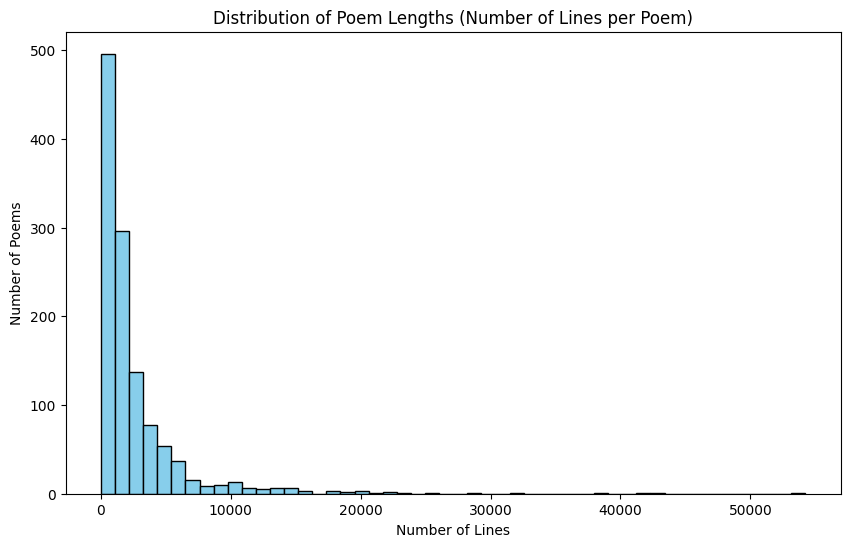


Sample from Class (gid): 19
Number of Lines: 5406
Poem Text:
The Song of Hiawatha is based on the legends and stories of many North American Indian tribes, but especially those of the Ojibway Indians of northern Michigan, Wisconsin, and Minnesota. They were collected by Henry Rowe Schoolcraft, the reknowned Schoolcraft married Jane, O-bah-bahm-wawa-ge-zhe-go-qua (The fur trader, and O-shau-gus-coday-way-qua (The Woman of the Green Prairie), who was a daughter of Waub-o-jeeg (The White Fisher), who was Chief of the Ojibway tribe at La Pointe, Wisconsin. Jane and her mother are credited with having researched, authenticated, and compiled much of the material Schoolcraft included in his Algic Researches (1839) and a revision published in 1856 as The Myth of Hiawatha.  It was this latter revision that Longfellow used as the basis for The Song of Hiawatha. Longfellow began Hiawatha on June 25, 1854, he completed it soon as the poem was  published its popularity was assured. However, it als

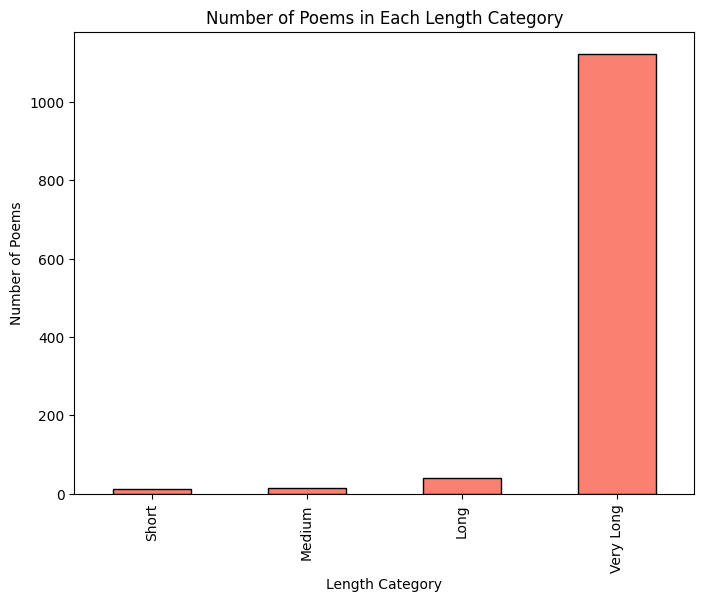


Class Imbalance Analysis:
length_category
Short          12
Medium         15
Long           41
Very Long    1123
Name: count, dtype: int64
Total dataset size after augmentation: 3573


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: poems.txt
  input_format: 
  model_prefix: bpe_tokenizer
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_

Training samples: 3215
Validation samples: 358

Sample Input Tokens: tensor([   2,  155,    7,  959, 1145, 7967,  292,    7,   36, 1209, 7967, 3751,
           7, 2861, 6488, 7980, 6461,  235,    7,  600,   44,  566, 7982,  251,
           6, 1482,  941,  616,  709, 7967,  251,    6,  376, 7978,   75, 1837,
        3030, 1398, 7967,  251,    7,  639,   59,   44,  369,   65,   41, 6115,
        7980,   81,   92, 3014, 7967,   81,   92, 6426, 7982, 1134,  236,   18,
        4208,   19,  214, 7954,  246,  150, 7980,   67,  236,  597,  795, 1227,
        7958,  930, 7958,  803, 7974,  233,  479,    7,  757,   45,   95,  236,
         128, 1671, 7980,   67,    7, 1761, 1996,   44,  236,    8, 1671, 6924,
          28, 1104,  236])
Sample Input Text: up the hillside, down the glen, rouse the sleeping citizen; summon out the might of men! like a lion growling low, like a night-storm rising slow, like the tread of unseen foe; it is coming, it is nigh! stand your homes and altars by; on your ow

In [ ]:
!pip install sentencepiece nltk rouge-score

import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import sentencepiece as spm
import os
import nltk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_path = '/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv'
df = pd.read_csv(data_path)

def combine_poems(df):
    poems = df.groupby('gid').agg(
        line_count=('s', 'count'),
        poem_text=('s', lambda x: ' '.join(x))
    ).reset_index()
    return poems

poems_df = combine_poems(df)
print(f'Total poems: {len(poems_df)}')

print(f'Total unique poems (classes): {len(poems_df)}')

plt.figure(figsize=(10,6))
plt.hist(poems_df['line_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Poem Lengths (Number of Lines per Poem)')
plt.xlabel('Number of Lines')
plt.ylabel('Number of Poems')
plt.show()

sample_poems = poems_df.head(5)
for idx, row in sample_poems.iterrows():
    print(f"\nSample from Class (gid): {row['gid']}")
    print(f"Number of Lines: {row['line_count']}")
    print(f"Poem Text:\n{row['poem_text']}\n")

poems_df['length_category'] = pd.cut(
    poems_df['line_count'], 
    bins=[0, 20, 50, 100, np.inf], 
    labels=['Short', 'Medium', 'Long', 'Very Long']
)

length_category_counts = poems_df['length_category'].value_counts().sort_index()

plt.figure(figsize=(8,6))
length_category_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Number of Poems in Each Length Category')
plt.xlabel('Length Category')
plt.ylabel('Number of Poems')
plt.show()

print("\nClass Imbalance Analysis:")
print(length_category_counts)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\n\s]", '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

poems_df['poem_text'] = poems_df['poem_text'].apply(preprocess_text)

nltk.download('punkt', quiet=True)

def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.uniform(0,1) > p]
    if len(new_words) == 0:
        new_words = [random.choice(words)]
    return ' '.join(new_words)

def random_swap(text, n=2):
    words = text.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

augmented_texts = []
for idx, row in poems_df.iterrows():
    text = row['poem_text']
    augmented_text_rd = random_deletion(text, p=0.1)
    augmented_text_rs = random_swap(text, n=3)
    augmented_texts.extend([augmented_text_rd, augmented_text_rs])

all_texts = poems_df['poem_text'].tolist() + augmented_texts

print(f'Total dataset size after augmentation: {len(all_texts)}')

temp_text_file = 'poems.txt'
with open(temp_text_file, 'w', encoding='utf-8') as f:
    for text in all_texts:
        f.write(text + '\n')

spm_model_prefix = 'bpe_tokenizer'
vocab_size = 8000

if not os.path.exists(f'{spm_model_prefix}.model'):
    spm.SentencePieceTrainer.Train(
        input=temp_text_file,
        model_prefix=spm_model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        character_coverage=1.0,
        unk_id=1,
        pad_id=0,
        bos_id=2,
        eos_id=3,
        user_defined_symbols=''
    )

tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{spm_model_prefix}.model')

class PoetryDataset(Dataset):
    def __init__(self, poems, tokenizer, max_length=100):
        self.poems = poems
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []
        self.targets = []
        self.prepare_data()
    
    def prepare_data(self):
        for poem in self.poems:
            tokens = self.tokenizer.encode(poem, out_type=int)
            tokens = [self.tokenizer.bos_id()] + tokens + [self.tokenizer.eos_id()]
            if len(tokens) > self.max_length:
                tokens = tokens[:self.max_length]
                tokens[-1] = self.tokenizer.eos_id()
            else:
                tokens += [self.tokenizer.pad_id()] * (self.max_length - len(tokens))
            self.inputs.append(tokens[:-1])
            self.targets.append(tokens[1:])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

total_poems = all_texts

random.shuffle(total_poems)

train_size = int(0.9 * len(total_poems))
train_poems = total_poems[:train_size]
val_poems = total_poems[train_size:]

train_dataset = PoetryDataset(train_poems, tokenizer, max_length=100)
val_dataset = PoetryDataset(val_poems, tokenizer, max_length=100)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

sample_idx = random.randint(0, len(train_dataset) - 1)
input_sample, target_sample = train_dataset[sample_idx]
print("\nSample Input Tokens:", input_sample)
print("Sample Input Text:", tokenizer.decode(input_sample.tolist()))
print("Sample Target Tokens:", target_sample)
print("Sample Target Text:", tokenizer.decode(target_sample.tolist()))

os.remove(temp_text_file)


In [4]:
!pip install matplotlib tqdm nltk rouge


Using device: cuda
TransformerModel(
  (embedding): Embedding(8000, 512, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (linear_q): Linear(in_features=512, out_features=512, bias=True)
        (linear_k): Linear(in_features=512, out_features=512, bias=True)
        (linear_v): Linear(in_features=512, out_features=512, bias=True)
        (linear_out): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_

/tmp/ipykernel_30/471436274.py:298: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1 Training:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_30/471436274.py:320: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Validation:   0%|          | 0/358 [00:00<?, ?it/s]/tmp/ipykernel_30/471436274.py:346: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.86it/s]


Epoch 1 | Train Loss: 7.9880 | Val Loss: 7.0722


Epoch 2 Validation: 100%|██████████| 358/358 [00:06<00:00, 58.77it/s]


Epoch 2 | Train Loss: 6.8375 | Val Loss: 6.4588


Epoch 3 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.33it/s]


Epoch 3 | Train Loss: 6.1216 | Val Loss: 5.8418


Epoch 4 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.96it/s]


Epoch 4 | Train Loss: 5.4992 | Val Loss: 5.3498


Epoch 5 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.41it/s]


Epoch 5 | Train Loss: 4.9201 | Val Loss: 4.8972


Epoch 6 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.83it/s]


Epoch 6 | Train Loss: 4.3254 | Val Loss: 4.4071


Epoch 7 Validation: 100%|██████████| 358/358 [00:05<00:00, 60.01it/s]


Epoch 7 | Train Loss: 3.7298 | Val Loss: 3.9449


Epoch 8 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.08it/s]


Epoch 8 | Train Loss: 3.1810 | Val Loss: 3.4323


Epoch 9 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.36it/s]


Epoch 9 | Train Loss: 2.7591 | Val Loss: 3.0715


Epoch 10 Validation: 100%|██████████| 358/358 [00:05<00:00, 60.20it/s]


Epoch 10 | Train Loss: 2.5145 | Val Loss: 2.8253


Epoch 11 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.46it/s]


Epoch 11 | Train Loss: 2.4039 | Val Loss: 2.7355


Epoch 12 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.84it/s]


Epoch 12 | Train Loss: 2.3816 | Val Loss: 2.7344


Epoch 13 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.55it/s]


Epoch 13 | Train Loss: 2.3882 | Val Loss: 2.6783


Epoch 14 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.85it/s]


Epoch 14 | Train Loss: 2.4647 | Val Loss: 2.7712


Epoch 15 Validation: 100%|██████████| 358/358 [00:05<00:00, 60.14it/s]


Epoch 15 | Train Loss: 2.4988 | Val Loss: 2.8304


Epoch 16 Validation: 100%|██████████| 358/358 [00:06<00:00, 58.43it/s]


Epoch 16 | Train Loss: 2.5421 | Val Loss: 2.8192


Epoch 17 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.35it/s]


Epoch 17 | Train Loss: 2.5851 | Val Loss: 2.8942


Epoch 18 Validation: 100%|██████████| 358/358 [00:06<00:00, 58.82it/s]


Epoch 18 | Train Loss: 2.6448 | Val Loss: 2.9006


Epoch 19 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.29it/s]


Epoch 19 | Train Loss: 2.6799 | Val Loss: 2.9498


Epoch 20 Validation: 100%|██████████| 358/358 [00:06<00:00, 59.56it/s]


Epoch 20 | Train Loss: 2.7715 | Val Loss: 3.0308


Epoch 21 Validation: 100%|██████████| 358/358 [00:06<00:00, 58.74it/s]


Epoch 21 | Train Loss: 2.7286 | Val Loss: 3.1575


Epoch 22 Validation: 100%|██████████| 358/358 [00:05<00:00, 59.72it/s]


Epoch 22 | Train Loss: 2.8548 | Val Loss: 3.2920


Epoch 23 Validation: 100%|██████████| 358/358 [00:05<00:00, 60.02it/s]


Epoch 23 | Train Loss: 2.8968 | Val Loss: 3.5277
Early stopping triggered


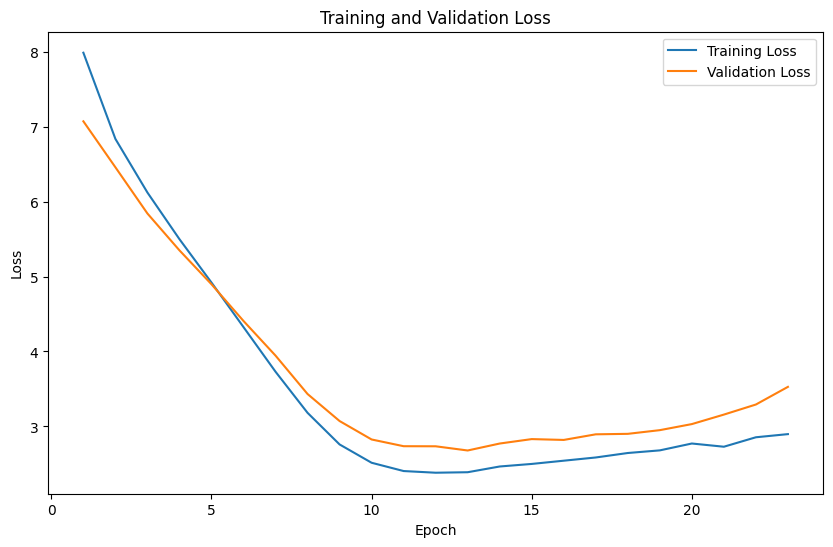

/tmp/ipykernel_30/471436274.py:387: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))
Evaluating Metrics: 100%|██

BLEU Score: 0.0027
ROUGE Scores: {'rouge-1': {'r': 0.15198214136226937, 'p': 0.17012053095998386, 'f': 0.15845020065940693}, 'rouge-2': {'r': 0.014683906581876264, 'p': 0.01576635291112153, 'f': 0.015055607061298248}, 'rouge-l': {'r': 0.12565125625921067, 'p': 0.1407258618069544, 'f': 0.13101806243778136}}
Generated Poetry:
the grass grow hood the other come again together where i have seen; tell me green, a private man i have seen a mother once more on a window-five,-- a tribe; and a letter--not the world, you, fate of truth will not known; and there you, the great poppies grow every tribe; andkin mark it seems as intuped upon the great men desire in everybody's weary springs and all, one hears it seems


In [ ]:
!pip install sentencepiece nltk rouge-score

import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import sentencepiece as spm
import os
import nltk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_path = '/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv'
df = pd.read_csv(data_path)

def combine_poems(df):
    poems = df.groupby('gid').agg(
        line_count=('s', 'count'),
        poem_text=('s', lambda x: ' '.join(x))
    ).reset_index()
    return poems

poems_df = combine_poems(df)
print(f'Total poems: {len(poems_df)}')

print(f'Total unique poems (classes): {len(poems_df)}')

plt.figure(figsize=(10,6))
plt.hist(poems_df['line_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Poem Lengths (Number of Lines per Poem)')
plt.xlabel('Number of Lines')
plt.ylabel('Number of Poems')
plt.show()

sample_poems = poems_df.head(5)
for idx, row in sample_poems.iterrows():
    print(f"\nSample from Class (gid): {row['gid']}")
    print(f"Number of Lines: {row['line_count']}")
    print(f"Poem Text:\n{row['poem_text']}\n")

poems_df['length_category'] = pd.cut(
    poems_df['line_count'], 
    bins=[0, 20, 50, 100, np.inf], 
    labels=['Short', 'Medium', 'Long', 'Very Long']
)

length_category_counts = poems_df['length_category'].value_counts().sort_index()

plt.figure(figsize=(8,6))
length_category_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Number of Poems in Each Length Category')
plt.xlabel('Length Category')
plt.ylabel('Number of Poems')
plt.show()

print("\nClass Imbalance Analysis:")
print(length_category_counts)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\n\s]", '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

poems_df['poem_text'] = poems_df['poem_text'].apply(preprocess_text)

nltk.download('punkt', quiet=True)

def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.uniform(0,1) > p]
    if len(new_words) == 0:
        new_words = [random.choice(words)]
    return ' '.join(new_words)

def random_swap(text, n=2):
    words = text.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

augmented_texts = []
for idx, row in poems_df.iterrows():
    text = row['poem_text']
    augmented_text_rd = random_deletion(text, p=0.1)
    augmented_text_rs = random_swap(text, n=3)
    augmented_texts.extend([augmented_text_rd, augmented_text_rs])

all_texts = poems_df['poem_text'].tolist() + augmented_texts

print(f'Total dataset size after augmentation: {len(all_texts)}')

temp_text_file = 'poems.txt'
with open(temp_text_file, 'w', encoding='utf-8') as f:
    for text in all_texts:
        f.write(text + '\n')

spm_model_prefix = 'bpe_tokenizer'
vocab_size = 8000

if not os.path.exists(f'{spm_model_prefix}.model'):
    spm.SentencePieceTrainer.Train(
        input=temp_text_file,
        model_prefix=spm_model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        character_coverage=1.0,
        unk_id=1,
        pad_id=0,
        bos_id=2,
        eos_id=3,
        user_defined_symbols=''
    )

tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{spm_model_prefix}.model')

class PoetryDataset(Dataset):
    def __init__(self, poems, tokenizer, max_length=100):
        self.poems = poems
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []
        self.targets = []
        self.prepare_data()
    
    def prepare_data(self):
        for poem in self.poems:
            tokens = self.tokenizer.encode(poem, out_type=int)
            tokens = [self.tokenizer.bos_id()] + tokens + [self.tokenizer.eos_id()]
            if len(tokens) > self.max_length:
                tokens = tokens[:self.max_length]
                tokens[-1] = self.tokenizer.eos_id()
            else:
                tokens += [self.tokenizer.pad_id()] * (self.max_length - len(tokens))
            self.inputs.append(tokens[:-1])
            self.targets.append(tokens[1:])
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

total_poems = all_texts

random.shuffle(total_poems)

train_size = int(0.9 * len(total_poems))
train_poems = total_poems[:train_size]
val_poems = total_poems[train_size:]

train_dataset = PoetryDataset(train_poems, tokenizer, max_length=100)
val_dataset = PoetryDataset(val_poems, tokenizer, max_length=100)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

sample_idx = random.randint(0, len(train_dataset) - 1)
input_sample, target_sample = train_dataset[sample_idx]
print("\nSample Input Tokens:", input_sample)
print("Sample Input Text:", tokenizer.decode(input_sample.tolist()))
print("Sample Target Tokens:", target_sample)
print("Sample Target Text:", tokenizer.decode(target_sample.tolist()))

os.remove(temp_text_file)
